In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set()
plt.style.use('bmh')

In [4]:
df=pd.read_csv(r'C:\Users\dorot\Downloads\AB testing\AB_Clicks.csv')
df.head()

,user_id,group,views,clicks
0,1,control,10.0,0.0
1,2,control,1.0,0.0
2,3,control,1.0,0.0
3,4,control,2.0,0.0
4,5,control,3.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  120000 non-null  int64  
 1   group    120000 non-null  object 
 2   views    120000 non-null  float64
 3   clicks   120000 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


In [8]:
df.describe()

,user_id,views,clicks
count,120000.000000,120000.000000,120000.000000
mean,60000.500000,4.991075,0.182692
std,34641.160489,5.915200,0.472547
min,1.000000,1.000000,0.000000
25%,30000.750000,2.000000,0.000000
50%,60000.500000,3.000000,0.000000
75%,90000.250000,6.000000,0.000000
max,120000.000000,205.000000,9.000000


In [16]:
df[df.duplicated()]

,user_id,group,views,clicks


In [12]:
print('Unique groups: ', df['group'].unique())

Unique groups:  ['control' 'test']


In [14]:
df['group'].value_counts()

group
control    60000
test       60000
Name: count, dtype: int64

In [11]:
df['converted'] = df['clicks'] > 0
df['converted'].replace({True:1,False:0},inplace=True)
df.head()

,user_id,group,views,clicks,converted
0,1,control,10.0,0.0,0
1,2,control,1.0,0.0,0
2,3,control,1.0,0.0,0
3,4,control,2.0,0.0,0
4,5,control,3.0,0.0,0


In [32]:
df['ctr'] = df['clicks'] / df['views']

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    120000 non-null  int64  
 1   group      120000 non-null  object 
 2   views      120000 non-null  float64
 3   clicks     120000 non-null  float64
 4   converted  120000 non-null  int64  
 5   ctr        120000 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 5.5+ MB


In [40]:
#summary = df.groupby('group').agg(total_conversions=('converted', 'sum'),total_users=('user_id', 'count')).reset_index()
#summary

,group,total_conversions,total_users
0,control,8820,60000
1,test,9703,60000


In [50]:
total_users = df.groupby('group')['user_id'].count()
total_conversions = df.groupby('group')['converted'].sum()
summary = pd.DataFrame({
    'total_users': total_users,
    'total_conversions': total_conversions
})
summary['conversion_rate (%)'] = 100 * summary['total_conversions'] / summary['total_users']
summary

,total_users,total_conversions,conversion_rate (%)
group,,,
control,60000,8820,14.700000
test,60000,9703,16.171667


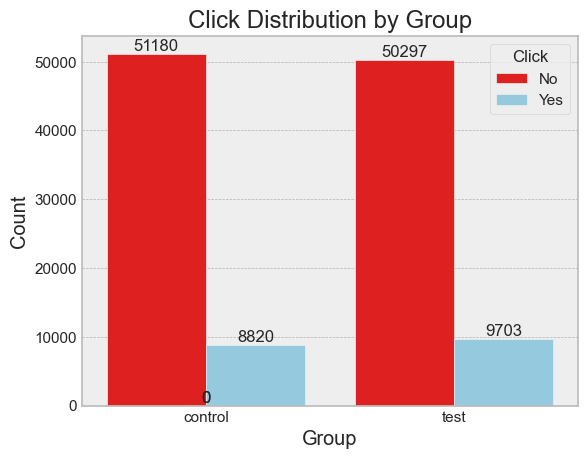

In [48]:
palette={0:'red',1:'skyblue'}
ax=sns.countplot(data=df,x='group',hue='converted',palette=palette)
plt.title('Click Distribution by Group')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Click',labels=['No','Yes'])

for p in ax.patches:
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{count}', (x, y), ha='center', va='bottom')
    
plt.show()

In [54]:
#significance level
alpha=0.05
#minimum detectable effect
delta=0.1

In [74]:
X_control=df[df['group']=='control'].groupby('group')['converted'].sum().values[0]
X_test=df[df['group']=='test'].groupby('group')['converted'].sum().values[0]
N_control=df[df['group']=='control'].groupby('group')['group'].count().values[0]
N_test=df[df['group']=='test'].groupby('group')['group'].count().values[0]
print('Total Clicks for Control Group:', X_control)
print('Total Clicks for Test Group:', X_test)
print('Total Users for Control Group:', N_control)
print('Total Users for Test Group:', N_test)

Total Clicks for Control Group: 8820
Total Clicks for Test Group: 9703
Total Users for Control Group: 60000
Total Users for Test Group: 60000


### Calculating Pooled Estimates

In [87]:
p_con_hat=X_control/N_control
p_test_hat=X_test/N_test
print('Click Probability in Control group:',round(p_con_hat,3))
print('Click Probability in Test group:',round(p_test_hat,3))
p_pooled_hat=(X_test+X_control)/(N_test+N_control)
print('Pooled Click Probability:',round(p_pooled_hat,3))

Click Probability in Control group: 0.147
Click Probability in Test group: 0.162
Pooled Click Probability: 0.154


### Calculating Pooled Variance

In [95]:
pooled_variance=p_pooled_hat*(1-p_pooled_hat)*(1/N_control+1/N_test)
print('p_pooled:',round(p_pooled_hat,4))
print('pooled_variance:',pooled_variance)

p_pooled: 0.1544
pooled_variance: 4.351061275462963e-06


### Calculating Standard Error and Test Statistics

In [97]:
SE=np.sqrt(pooled_variance)
print('Standard Error:',SE)
test_stat=(p_con_hat-p_test_hat)/SE
print('Test Statistics for 2-sample Z test:',test_stat)
Z_crit=norm.ppf(1-alpha/2)
print('Z-critical value from Standard Normal distribution:',Z_crit)

Standard Error: 0.002085919767264063
Test Statistics for 2-sample Z test: -7.055241000937145
Z-critical value from Standard Normal distribution: 1.959963984540054


### Calculating p values of the Z test   
p<=0.05, reject null   
p>0.05, we fail to reject null

In [104]:
p_value=2*norm.sf(abs(test_stat))
def is_statical_significance(p_value,alpha):
    print(f'P-value of the 2-sample Z-test: {round(p_value,3)}')
    if p_value<alpha:
        print('There is statistical significance')
    else:
        print('There is no statistical significance')

is_statical_significance(p_value,alpha)

P-value of the 2-sample Z-test: 0.0
There is statistical significance


In [128]:
control_ctrs = df[df['group'] == 'control']['ctr']
test_ctrs = df[df['group'] == 'test']['ctr']

from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(control_ctrs, test_ctrs, equal_var=False)
print(f"T-test: {t_stat}")
print(f"p_val: {p_val:.11f}")

T-test: -5.871485328700066
p_val: 0.00000000433


In [110]:
mean_control_ctr = control_ctrs.mean()
mean_test_ctr = test_ctrs.mean()

print(f"Mean CTR - Control Group: {mean_control_ctr:.4f}")
print(f"Mean CTR - Test Group:    {mean_test_ctr:.4f}")

Mean CTR - Control Group: 0.0347
Mean CTR - Test Group:    0.0386


In [112]:
std_control = control_ctrs.std()
std_test = test_ctrs.std()

n1, n2 = len(control_ctrs), len(test_ctrs)
pooled_std = np.sqrt(((n1 - 1)*std_control**2 + (n2 - 1)*std_test**2) / (n1 + n2 - 2))

cohen_d = (mean_test_ctr - mean_control_ctr) / pooled_std
print(f"Cohen's d: {cohen_d:.3f}")

Cohen's d: 0.034


In [7]:
from scipy.stats import ttest_ind

# Get clicks for each user in both groups
control_clicks = df[df['group'] == 'control']['clicks']
test_clicks = df[df['group'] == 'test']['clicks']

# Summary stats
print(f'Avg clicks per user - Control: {control_clicks.mean():.3f}')
print(f'Avg clicks per user - Test: {test_clicks.mean():.3f}')

# Two-sample t-test
t_stat, p_val = ttest_ind(test_clicks, control_clicks, equal_var=False)  # Welch's t-test is safer
print(f'T-statistic: {t_stat:.3f}')
print(f'P-value: {p_val:.3f}')

# Interpret
alpha = 0.05
if p_val < alpha:
    print("Statistically significant difference in average clicks.")
else:
    print("No statistically significant difference in average clicks.")


Avg clicks per user - Control: 0.172
Avg clicks per user - Test: 0.194
T-statistic: 8.048
P-value: 0.000
Statistically significant difference in average clicks.
